In [142]:
import os

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


In [143]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [144]:
import cv2

In [145]:
import matplotlib.pyplot as plt

In [146]:
%matplotlib inline

In [147]:
from sklearn.model_selection import train_test_split

In [148]:
import tensorflow as tf

In [149]:
from tensorflow.keras.models import Model

In [150]:
from keras.layers import *
#from keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

In [151]:
IMAGE_LIB = '../Cell-data/cell_images/'
MASK_LIB = '../Cell-data/cell_masks/'
IMG_HEIGHT, IMG_WIDTH = 32, 32
SEED=42

In [152]:
all_images = [x for x in sorted(os.listdir(IMAGE_LIB)) if x[-4:] == '.jpg']

In [153]:
# print(all_images)

imagesWithoutMask = []
imagesWithMask = []

for eachImgName in all_images:
    foundMaskPath = False
    for eachMaskImgPath in os.listdir(MASK_LIB):
        if eachImgName[:-4] in eachMaskImgPath:
            imagesWithMask.append(eachImgName)
            foundMaskPath = True
    if not foundMaskPath:
        imagesWithoutMask.append(eachImgName)


# print(imagesWithoutMask)
# print(len(imagesWithoutMask))


In [154]:
x_data = np.empty((len(imagesWithMask), IMG_HEIGHT, IMG_WIDTH), dtype='float32')

In [155]:
for i, name in enumerate(imagesWithMask):
    im = cv2.imread(IMAGE_LIB + name, cv2.IMREAD_UNCHANGED).astype("int16").astype('float32')
    im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    im_gray = cv2.resize(im_gray, dsize=(IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_LANCZOS4)
    im_gray = (im_gray - np.min(im_gray)) / (np.max(im_gray) - np.min(im_gray))
    x_data[i] = im_gray

In [156]:
y_data = np.empty((len(imagesWithMask), IMG_HEIGHT, IMG_WIDTH), dtype='float32')
for i, name in enumerate(imagesWithMask):
    im = cv2.imread(MASK_LIB + name[:-4] + "_mask_AWA.jpg", cv2.IMREAD_UNCHANGED).astype('float32')/255.
    im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    im_gray = cv2.resize(im_gray, dsize=(IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_NEAREST)
    y_data[i] = im_gray

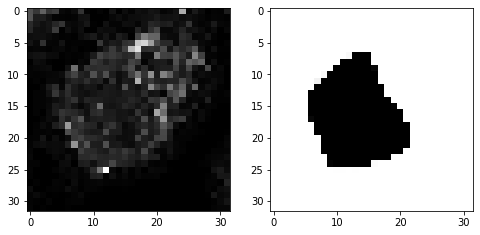

In [157]:
fig, ax = plt.subplots(1,2, figsize = (8,4))
ax[0].imshow(x_data[12], cmap='gray')
ax[1].imshow(y_data[12], cmap='gray')
plt.show()

In [158]:
x_data = x_data[:,:,:,np.newaxis]
y_data = y_data[:,:,:,np.newaxis]
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size = 0.5)

In [159]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

In [160]:
input_layer = Input(shape=x_train.shape[1:])
c1 = Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(input_layer)
l = MaxPool2D(strides=(2,2))(c1)
c2 = Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c2)
c3 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c3)
c4 = Conv2D(filters=32, kernel_size=(1,1), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(c4), c3], axis=-1)
l = Conv2D(filters=32, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c2], axis=-1)
l = Conv2D(filters=24, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c1], axis=-1)
l = Conv2D(filters=16, kernel_size=(2,2), activation='relu', padding='same')(l)
l = Conv2D(filters=64, kernel_size=(1,1), activation='relu')(l)
l = Dropout(0.5)(l)
output_layer = Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid')(l)
                                                         
model = Model(input_layer, output_layer)


In [161]:
 model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d_27 (Conv2D)             (None, 32, 32, 8)    80          ['input_4[0][0]']                
                                                                                                  
 max_pooling2d_9 (MaxPooling2D)  (None, 16, 16, 8)   0           ['conv2d_27[0][0]']              
                                                                                                  
 conv2d_28 (Conv2D)             (None, 16, 16, 16)   1168        ['max_pooling2d_9[0][0]']        
                                                                                            

In [162]:
def my_generator(x_train, y_train, batch_size):
    data_generator = ImageDataGenerator(
            width_shift_range=0.1,
            height_shift_range=0.1,
            rotation_range=10,
            zoom_range=0.1).flow(x_train, x_train, batch_size, seed=SEED)
    mask_generator = ImageDataGenerator(
            width_shift_range=0.1,
            height_shift_range=0.1,
            rotation_range=10,
            zoom_range=0.1).flow(y_train, y_train, batch_size, seed=SEED)
    while True:
        x_batch, _ = data_generator.next()
        y_batch, _ = mask_generator.next()
        yield x_batch, y_batch

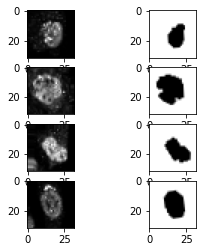

In [163]:
image_batch, mask_batch = next(my_generator(x_train, y_train, 8))
fix, ax = plt.subplots(4,2, figsize=(4,4))
for i in range(4):
    ax[i,0].imshow(image_batch[i,:,:,0], cmap='gray')
    ax[i,1].imshow(mask_batch[i,:,:,0], cmap ='gray')
plt.show()

In [164]:
model.compile( loss='binary_crossentropy', metrics=[dice_coef])

In [165]:
weight_saver = ModelCheckpoint('cell.h5', monitor='val_dice_coef', 
                                              save_best_only=True, save_weights_only=True)
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.8 ** x)

In [166]:
hist = model.fit(
    my_generator(x_train, y_train, 8),
    steps_per_epoch=200,
    validation_data=(x_val, y_val),
    epochs=10,
    verbose=2,
    callbacks=[weight_saver, annealer],
)


Epoch 1/10
200/200 - 4s - loss: 0.2673 - dice_coef: 0.8842 - val_loss: 0.1936 - val_dice_coef: 0.9284 - lr: 0.0010 - 4s/epoch - 20ms/step
Epoch 2/10
200/200 - 3s - loss: 0.1691 - dice_coef: 0.9326 - val_loss: 0.2172 - val_dice_coef: 0.9346 - lr: 8.0000e-04 - 3s/epoch - 16ms/step
Epoch 3/10
200/200 - 3s - loss: 0.1417 - dice_coef: 0.9438 - val_loss: 0.2112 - val_dice_coef: 0.9306 - lr: 6.4000e-04 - 3s/epoch - 14ms/step
Epoch 4/10
200/200 - 3s - loss: 0.1236 - dice_coef: 0.9510 - val_loss: 0.1757 - val_dice_coef: 0.9438 - lr: 5.1200e-04 - 3s/epoch - 14ms/step
Epoch 5/10
200/200 - 2s - loss: 0.1112 - dice_coef: 0.9559 - val_loss: 0.1874 - val_dice_coef: 0.9446 - lr: 4.0960e-04 - 2s/epoch - 12ms/step
Epoch 6/10
200/200 - 3s - loss: 0.1029 - dice_coef: 0.9593 - val_loss: 0.1800 - val_dice_coef: 0.9488 - lr: 3.2768e-04 - 3s/epoch - 13ms/step
Epoch 7/10
200/200 - 3s - loss: 0.0963 - dice_coef: 0.9620 - val_loss: 0.1865 - val_dice_coef: 0.9490 - lr: 2.6214e-04 - 3s/epoch - 13ms/step
Epoch 8/10

In [179]:
model.load_weights('cell.h5')

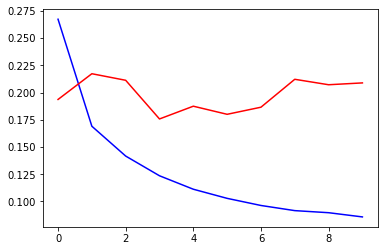

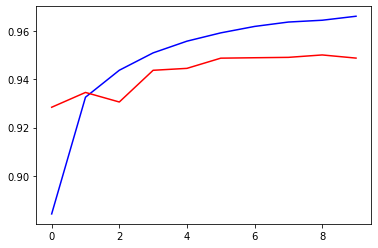

In [180]:
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()
plt.plot(hist.history['dice_coef'], color='b')
plt.plot(hist.history['val_dice_coef'], color='r')
plt.show()

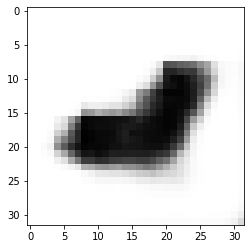

In [187]:
plt.imshow(x_train[5],cmap='gray')
plt.imshow(model.predict(x_train[5].reshape(1,IMG_HEIGHT, IMG_WIDTH, 1))[0,:,:,0], cmap='gray')

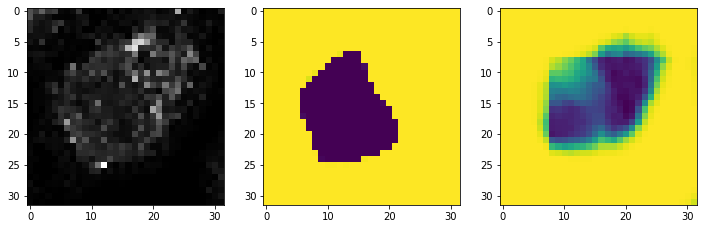

In [188]:
y_hat = model.predict(x_val)
fig, ax = plt.subplots(1,3,figsize=(12,6))
ax[0].imshow(x_val[0,:,:,0], cmap='gray')
ax[1].imshow(y_val[0,:,:,0])
ax[2].imshow(y_hat[0,:,:,0])

In [171]:
len(x_val)


24

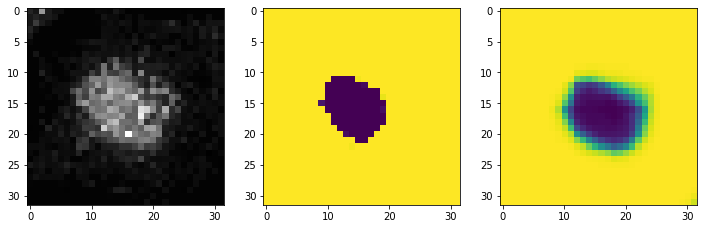

In [190]:
fig, ax = plt.subplots(1,3,figsize=(12,6))
ax[0].imshow(x_val[12,:,:,0], cmap='gray')
ax[1].imshow(y_val[12,:,:,0])
ax[2].imshow(y_hat[12,:,:,0])


In [191]:
cv2.imwrite('prediction_12.png',y_hat[12,:,:,0])

True

In [192]:
y_hat_new = 255*y_hat[12,:,:,0]

In [193]:
y_hat_new

array([[254.99963, 254.99939, 254.99887, ..., 254.9973 , 254.97469,
        254.52087],
       [254.99957, 254.99942, 254.99908, ..., 254.9969 , 254.97307,
        254.516  ],
       [254.99954, 254.99933, 254.9992 , ..., 254.99657, 254.9716 ,
        254.51585],
       ...,
       [254.99936, 254.99945, 254.99957, ..., 254.98364, 254.86865,
        253.34596],
       [254.98756, 254.98897, 254.99072, ..., 254.76117, 253.73112,
        249.08951],
       [254.83447, 254.84978, 254.86243, ..., 253.42882, 250.59433,
        237.62422]], dtype=float32)

In [194]:
y_hat_new.astype(int)

array([[254, 254, 254, ..., 254, 254, 254],
       [254, 254, 254, ..., 254, 254, 254],
       [254, 254, 254, ..., 254, 254, 254],
       ...,
       [254, 254, 254, ..., 254, 254, 253],
       [254, 254, 254, ..., 254, 253, 249],
       [254, 254, 254, ..., 253, 250, 237]])

In [195]:
cv2.imwrite('prediction_12.png',y_hat_new)

True